# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.

### Data Dictionary

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [3]:
import os
import numpy as np                                                                               
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt                                                                  
import math                                                                                      
import cv2                                                                                      
import seaborn as sns                                                                            


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              
from tensorflow.keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16                                                  
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                                 
from sklearn import preprocessing                                                                
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix, classification_report                                                     
from sklearn.preprocessing import LabelBinarizer                                                  
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [5]:
# Load the image file of dataset
images = np.load('images.npy')      

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')  

## Data Overview

### Understand the shape of the dataset

In [6]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

**1. How are these different category plant images different from each other?**

In [7]:
def plot_images(images,labels):
    num_classes=12                                                                  
    categories=np.unique(labels)
    keys=dict(labels['Label'])                                                      
    rows = 3                                                                        
    cols = 4                                                                        
    fig = plt.figure(figsize=(10, 8))                                               
    
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
            ax.imshow(images[random_index, :])                                      # Plotting the image
            ax.set_title(keys[random_index])
    plt.show()

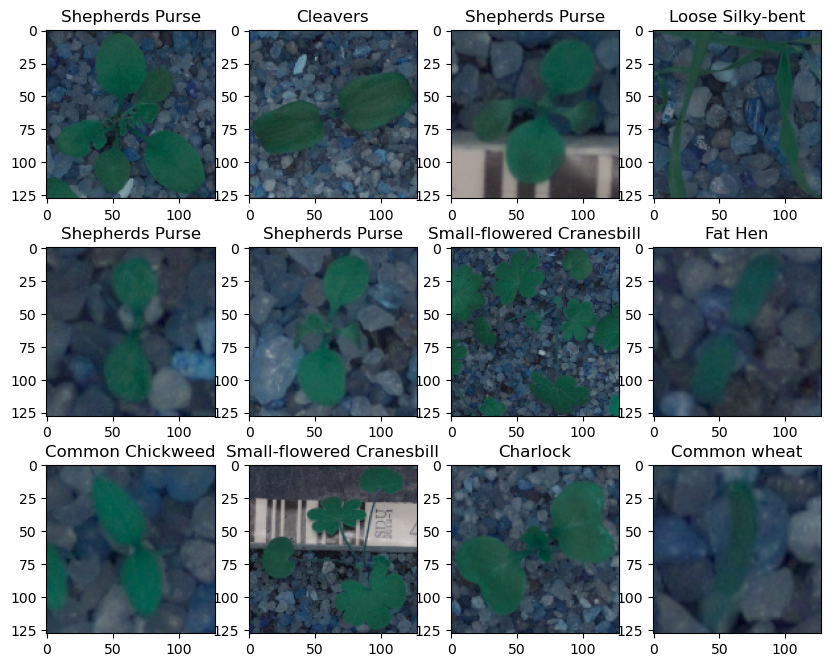

In [8]:
plot_images(images,labels)

In [9]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

**2. Is the dataset provided imbalanced?  Yes.**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

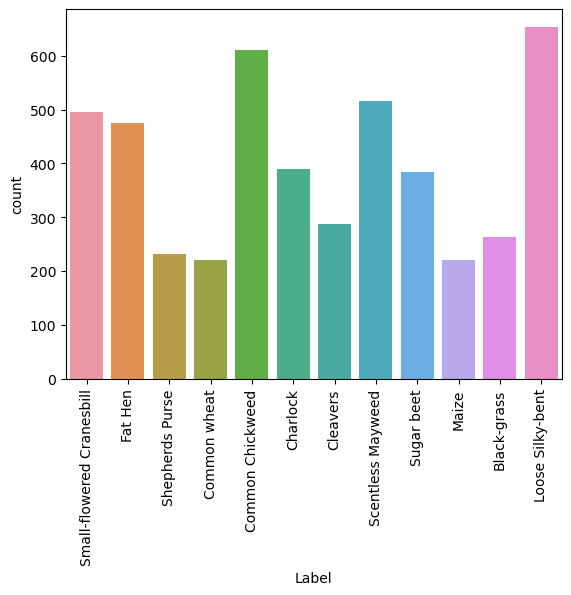

In [10]:
sns.countplot(x = 'Label', data = labels)
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [11]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

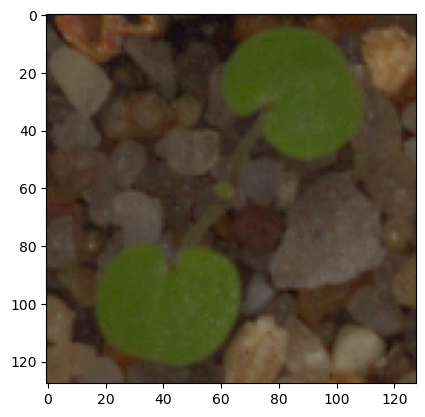

In [12]:
#before resizing
plt.imshow(images[5])

In [13]:
images_decreased=[]
height = 64                    
width =  64                    
dimensions = (width, height)
for i in range(len(images)):
    images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

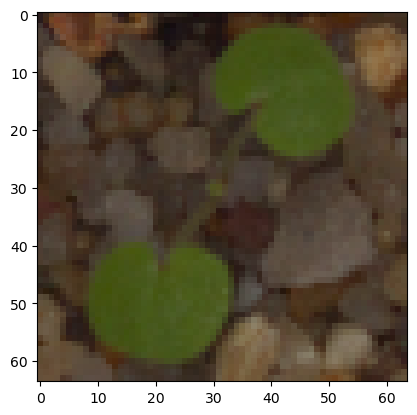

In [14]:
#after resizing
plt.imshow(images_decreased[5])

### Data Preparation for Modeling

**Split the dataset**

In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels , test_size=0.1, random_state=42, stratify=labels)   
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42,stratify=y_temp)                       

In [16]:
#shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [17]:
# Convert labels from names to one hot vectors using Labelbinarizer

enc = LabelBinarizer()         #intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        
y_val_encoded=enc.transform(y_val)                  
y_test_encoded=enc.transform(y_test)                

In [18]:
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape   

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [19]:
#normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [20]:
# Clearing backend
backend.clear_session()

In [21]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [22]:
# Intializing a sequential model
model1 = Sequential()                             

model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

#add max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#flatten the output of the conv layer
model1.add(Flatten())

#a fully connected dense layer 
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

#the output layer 
model1.add(Dense(12, activation='softmax'))

#Adam Optimizer
opt=tf.keras.optimizers.legacy.Adam()

#Compile model 
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [23]:
#fit the model on train set, using validation set for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized, y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30


2024-12-17 21:11:04.280122: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


121/121 - 5s - loss: 2.4519 - accuracy: 0.1146 - val_loss: 2.4355 - val_accuracy: 0.1285 - 5s/epoch - 44ms/step
Epoch 2/30
121/121 - 5s - loss: 2.3483 - accuracy: 0.1929 - val_loss: 2.1004 - val_accuracy: 0.3458 - 5s/epoch - 43ms/step
Epoch 3/30
121/121 - 5s - loss: 2.0634 - accuracy: 0.3073 - val_loss: 1.8412 - val_accuracy: 0.3855 - 5s/epoch - 43ms/step
Epoch 4/30
121/121 - 5s - loss: 1.8807 - accuracy: 0.3501 - val_loss: 1.6873 - val_accuracy: 0.4533 - 5s/epoch - 43ms/step
Epoch 5/30
121/121 - 5s - loss: 1.7425 - accuracy: 0.3735 - val_loss: 1.5544 - val_accuracy: 0.4860 - 5s/epoch - 43ms/step
Epoch 6/30
121/121 - 5s - loss: 1.6214 - accuracy: 0.4045 - val_loss: 1.4451 - val_accuracy: 0.5187 - 5s/epoch - 43ms/step
Epoch 7/30
121/121 - 5s - loss: 1.5734 - accuracy: 0.4377 - val_loss: 1.3283 - val_accuracy: 0.5561 - 5s/epoch - 43ms/step
Epoch 8/30
121/121 - 5s - loss: 1.4852 - accuracy: 0.4593 - val_loss: 1.2139 - val_accuracy: 0.5771 - 5s/epoch - 43ms/step
Epoch 9/30
121/121 - 5s - l

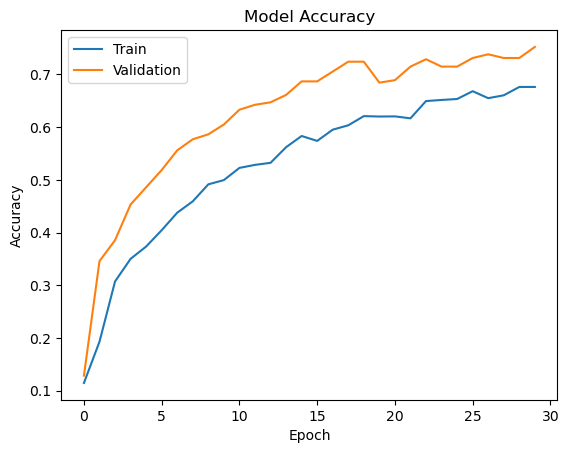

In [24]:
#Train-Val visualization
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
#evaluating model on test data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8511 - accuracy: 0.7179 - 225ms/epoch - 15ms/step


- **Training accuracy improves consistently but plateaus around 67%.** 
- **Validation accuracy peaks at ~75% and test accuracy at ~72%, showing that the model generalizes relatively well on unssen data**

In [26]:
#generating predictions using test data
y_pred=model1.predict(X_test_normalized)
y_pred

15/15 [==============================] - 0s 14ms/step


array([[1.09280073e-23, 1.70200618e-19, 3.52004576e-25, ...,
        1.58595722e-04, 1.17753064e-17, 1.38012322e-08],
       [1.12221499e-11, 5.99243902e-02, 4.37827664e-04, ...,
        8.27391166e-03, 9.26419497e-01, 4.44340287e-03],
       [4.00801744e-12, 2.94979494e-02, 1.25908322e-04, ...,
        3.80724180e-03, 9.63193238e-01, 3.13419593e-03],
       ...,
       [2.53472537e-01, 1.72946291e-09, 7.32537228e-05, ...,
        1.61049085e-09, 2.38704195e-10, 1.13700102e-04],
       [7.64091360e-11, 5.46622359e-05, 3.73295165e-07, ...,
        1.98243365e-01, 2.33813438e-07, 4.51077882e-04],
       [1.31938863e-10, 3.16894352e-02, 5.25212963e-04, ...,
        4.51954097e-01, 1.82286538e-02, 2.61891276e-01]], dtype=float32)

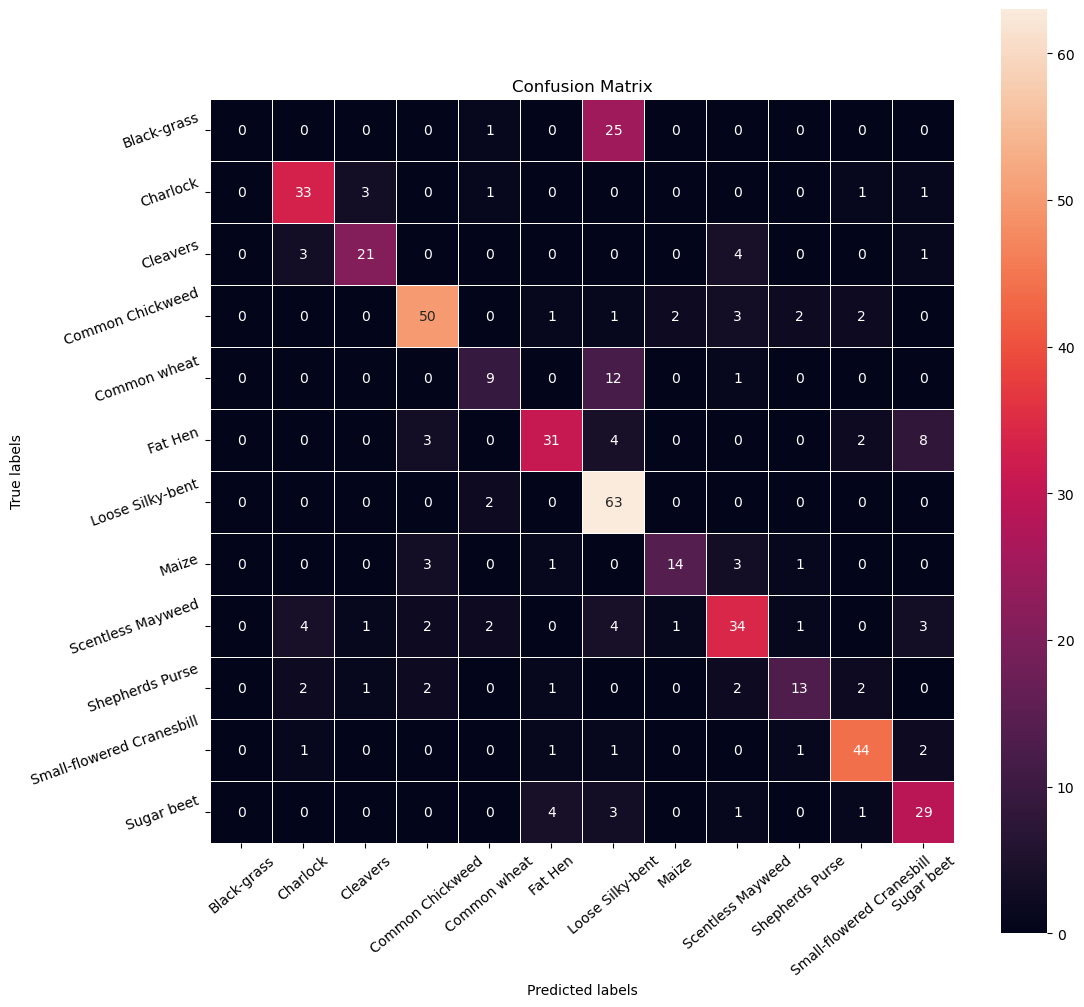

In [27]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

#Plotting the Confusion Matrix using 
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)

plt.show()

In [28]:
#Plotting the classification report
cr = classification_report(y_test_arg, y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.77      0.85      0.80        39
           2       0.81      0.72      0.76        29
           3       0.83      0.82      0.83        61
           4       0.60      0.41      0.49        22
           5       0.79      0.65      0.71        48
           6       0.56      0.97      0.71        65
           7       0.82      0.64      0.72        22
           8       0.71      0.65      0.68        52
           9       0.72      0.57      0.63        23
          10       0.85      0.88      0.86        50
          11       0.66      0.76      0.71        38

    accuracy                           0.72       475
   macro avg       0.68      0.66      0.66       475
weighted avg       0.70      0.72      0.70       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [29]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [30]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
#data augmentation
trainDataGen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [32]:
# Intializing a sequential model
model2 = Sequential()                             

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

#add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#flatten the output of the conv layer
model2.add(Flatten())

#a fully connected dense layer 
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))

#the output layer 
model2.add(Dense(12, activation='softmax'))

#Adam Optimizer
opt=tf.keras.optimizers.legacy.Adam()

#Compile model 
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [33]:
batch_size = 64
epochs = 50

history = model2.fit(trainDataGen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/50
 1/60 [..............................] - ETA: 10s - loss: 2.6800 - accuracy: 0.1094

2024-12-17 21:14:28.115566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 3s 39ms/step - loss: 2.1307 - accuracy: 0.2469 - val_loss: 2.3915 - val_accuracy: 0.2710 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 2s 38ms/step - loss: 1.6718 - accuracy: 0.4092 - val_loss: 2.2820 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 2s 38ms/step - loss: 1.4808 - accuracy: 0.4740 - val_loss: 2.1972 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 2s 39ms/step - loss: 1.4144 - accuracy: 0.5112 - val_loss: 2.1078 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 2s 39ms/step - loss: 1.3011 - accuracy: 0.5382 - val_loss: 1.8764 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 2s 39ms/step - loss: 1.2166 - accuracy: 0.5572 - val_loss: 1.7029 - val_accuracy: 0.4346 - lr: 0.0010
Epoch 7/50
60/60 [==============================] - 2s 39ms/step - loss: 1.1773 - accur

Epoch 46/50
60/60 [==============================] - 2s 41ms/step - loss: 0.7413 - accuracy: 0.7261 - val_loss: 0.7724 - val_accuracy: 0.7570 - lr: 1.0000e-05
Epoch 47/50
60/60 [==============================] - 2s 40ms/step - loss: 0.7558 - accuracy: 0.7264 - val_loss: 0.7608 - val_accuracy: 0.7710 - lr: 1.0000e-05
Epoch 48/50
60/60 [==============================] - 2s 40ms/step - loss: 0.7521 - accuracy: 0.7261 - val_loss: 0.7363 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 49/50
60/60 [==============================] - 2s 40ms/step - loss: 0.7457 - accuracy: 0.7219 - val_loss: 0.7471 - val_accuracy: 0.7757 - lr: 1.0000e-05
Epoch 50/50
60/60 [==============================] - 2s 40ms/step - loss: 0.7634 - accuracy: 0.7172 - val_loss: 0.7321 - val_accuracy: 0.7827 - lr: 1.0000e-05


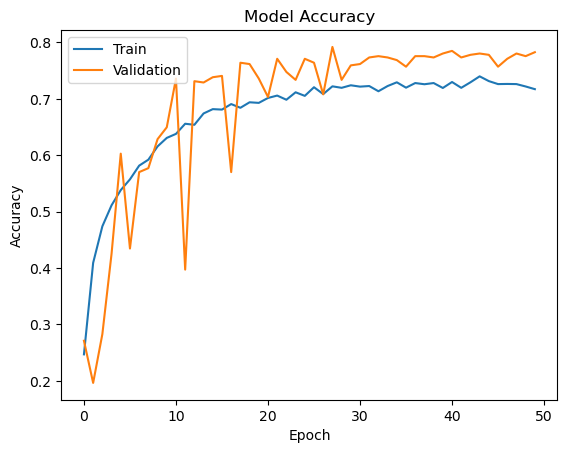

In [34]:
#Train-Val visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
#evaluating model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7401 - accuracy: 0.7832 - 138ms/epoch - 9ms/step


- **Training accuracy peaks around 72%.** 
- **Validation accuracy and test accuracy peaks at ~78%, showing that the model generalizes relatively well on unssen data.**

In [36]:
#generating predictions using test data
y_pred=model2.predict(X_test_normalized)
y_pred

15/15 [==============================] - 0s 8ms/step


array([[1.40405669e-08, 7.54280691e-08, 2.17669860e-09, ...,
        9.36180353e-04, 2.58755631e-06, 3.89093912e-05],
       [2.16082596e-09, 5.02692070e-04, 4.80718063e-06, ...,
        2.91229002e-02, 9.70202982e-01, 4.77771755e-05],
       [6.50087968e-05, 4.86478006e-04, 1.46781531e-04, ...,
        7.85480347e-03, 9.83064234e-01, 2.93906522e-03],
       ...,
       [2.15397432e-01, 1.89339880e-06, 7.95748565e-06, ...,
        4.35689600e-08, 1.88310267e-07, 1.78208375e-05],
       [4.05481296e-06, 4.38423944e-04, 1.00761368e-04, ...,
        1.34202391e-01, 1.40921352e-03, 1.89254421e-03],
       [3.60359089e-04, 3.38012725e-02, 3.29629511e-01, ...,
        2.94409990e-01, 1.14896275e-01, 1.40688252e-02]], dtype=float32)

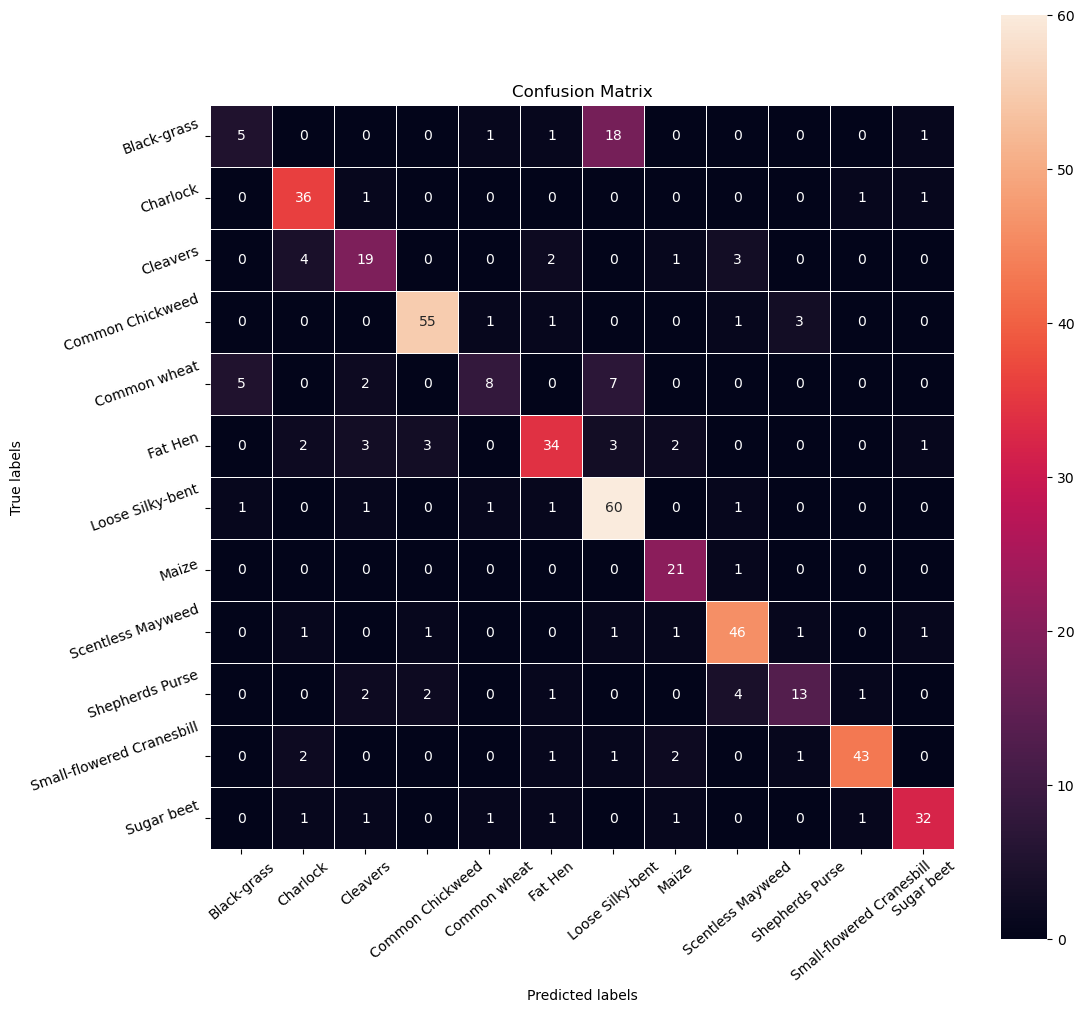

In [37]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

#Plotting the Confusion Matrix using 
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)

plt.show()

In [38]:
#Plotting the classification report
cr = classification_report(y_test_arg, y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.45      0.19      0.27        26
           1       0.78      0.92      0.85        39
           2       0.66      0.66      0.66        29
           3       0.90      0.90      0.90        61
           4       0.67      0.36      0.47        22
           5       0.81      0.71      0.76        48
           6       0.67      0.92      0.77        65
           7       0.75      0.95      0.84        22
           8       0.82      0.88      0.85        52
           9       0.72      0.57      0.63        23
          10       0.93      0.86      0.90        50
          11       0.89      0.84      0.86        38

    accuracy                           0.78       475
   macro avg       0.75      0.73      0.73       475
weighted avg       0.78      0.78      0.77       475



## Final Model

In [41]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation'],
              'Train Accuracy':['68%','72%'],'Validation Accuracy':['75%','78%'],
              'Test Accuracy':['72%','78%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,68%,75%,72%
1,CNN Model with Data Augmentation,72%,78%,78%


**Our second model performed better than the first, with approximately 78% test accuracy - about 6% better than the first model.** 

### Visualizing the prediction

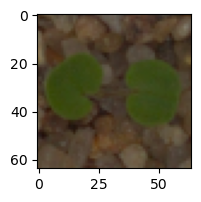

1/1 [==============================] - 0s 9ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


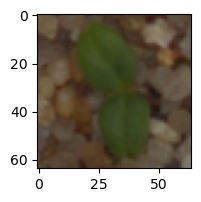

1/1 [==============================] - 0s 7ms/step
Predicted Label ['Cleavers']
True Label Cleavers


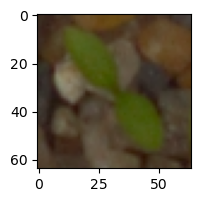

1/1 [==============================] - 0s 8ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


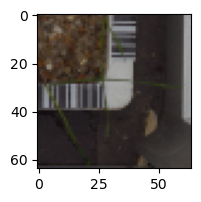

1/1 [==============================] - 0s 10ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [40]:
#Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()

##predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()

##predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                             

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()

##predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[38])
plt.show()

##predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3))))) 
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                             

## Actionable Insights and Business Recommendations

- Both models' performances indicate underfitting. Adding more convolutional layers or increasing the number of filters in existing layers to extract richer features might be helpful towards improving the models.

- Our second model performed better than the first, with approximately 78% test accuracy - about 6% better than the first model.

- Despite the ~78% test accuracy, the model can already automate significant portions of the manual classification task, saving time and reducing human errors.

- Prioritizing on improving accuracy for critical classes by identifying which plant categories are most misclassified and assessing their economic or agricultural importance.

_____